In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
# from src.folder_handler import *
from src.cort_processor import *
# from src.tdt_support import *
from src.plotter import *
# from src.decoders import *
import math
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
# from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
test_session = CortProcessor('/mnt/c/oobootoo/rat-fes/data/results-meplem923/meepo_fast_923')

read from t=0s to t=384.32s
read from t=0s to t=367.29s


In [5]:
neural = test_session.tdt_data[0]['neural']
fs = test_session.tdt_data[0]['fs']
print(fs)
print(len(test_session.tdt_data))
print(len(test_session.data['rates']))
filtered = filter_neural(neural, fs)
clean_filtered = remove_artifacts(filtered, fs)

24414.0625
2
17


In [32]:
spikes = autothreshold_crossings(clean_filtered, 3.0)
negspikes = autothreshold_crossings(clean_filtered, -3.0)

In [18]:
print(spikes[:,0])

[0 0 0 ... 0 0 0]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
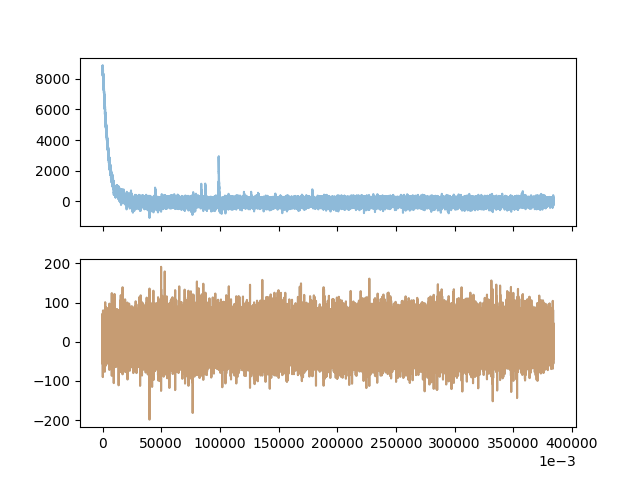

In [12]:
tsn = np.linspace(0, neural.shape[0]/fs,neural.shape[0])
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(tsn, neural[:,0], alpha = 0.5)
ax[1].plot(tsn, filtered[:,0], alpha = 0.5)
ax[1].plot(tsn, clean_filtered[:,0], alpha = 0.5)

ax[1].ticklabel_format(axis= 'x', style='sci', scilimits= [-3,-3], useOffset=True)

(15746,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
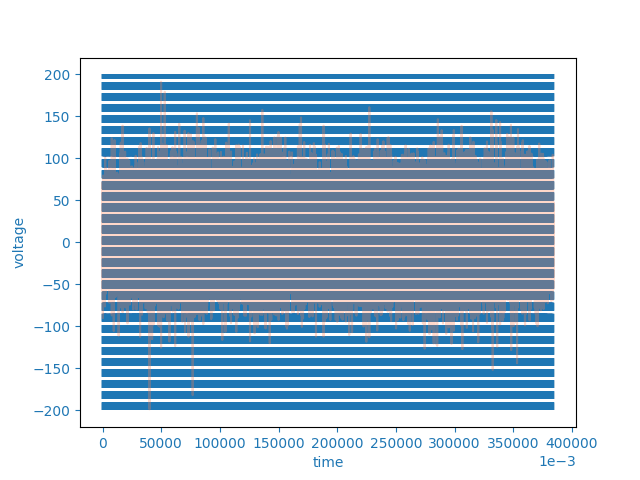

In [31]:
fig0=plt.figure()
ax=fig0.add_subplot(111, label="1")
ax.plot(tsn, clean_filtered[:,0],color=colors[color_index], alpha = 0.3)
line_list = []
for i in range(spikes.shape[0]):
    if spikes[i,0] == 1:
        line_list.append(tsn[i])
print(np.array(line_list).shape)
ax.vlines(np.array(line_list), ymin = -200, ymax = 200, linestyle='--', alpha=0.5)
ax.set_xlabel("time", color="C0")
ax.set_ylabel("voltage", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")
ax.ticklabel_format(axis= 'x', style='sci', scilimits= [-3,-3], useOffset=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
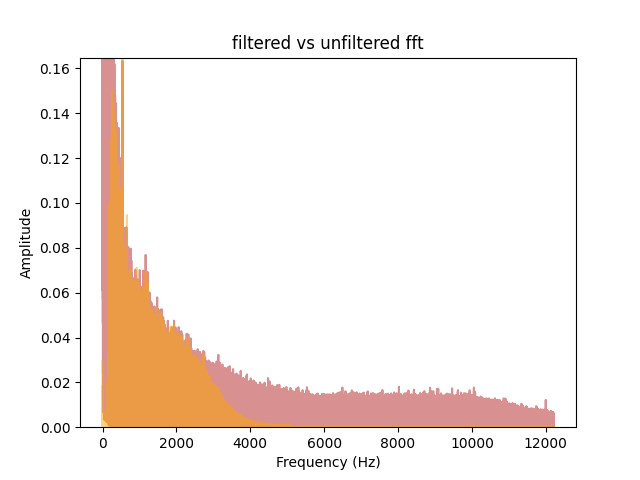

In [14]:
N = tsn.shape[0]
# sample spacing
T = tsn[1]-tsn[0]
x = tsn
y1 =  neural[:,0]
y1f = fft(y1)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y1fp = 2.0/N * np.abs(y1f[:N//2])
y2 = filtered[:,0]
y2f = fft(y2)
y2fp = 2.0/N * np.abs(y2f[:N//2])
# y3 = filter_test
# y3f = fft(y3)
# y3fp = 2.0/N * np.abs(y3f[:N//2])
# y0 = meppredicted_sin[:,6]
# y0f = fft(y0)
# y0fp = 2.0/N * np.abs(y0f[:N//2])
fig, ax = plt.subplots()
# ax.plot(xf, y0fp, alpha = 0.5, label='compare', c='skyblue')
ax.plot(xf, y1fp, alpha = 0.5, label='channel 0', c='firebrick')
# ax.plot(xf, y3fp, alpha = 0.5, label='filtered', c='palegreen')
ax.plot(xf, y2fp, alpha = 0.51, label='actual', c='orange')
ax.set(ylabel='Amplitude',xlabel='Frequency (Hz)',title='filtered vs unfiltered fft')
ax.set_ylim([0, y2fp[np.argsort(y2fp, axis=0)[-2]] * 1.1]) 
# ax.legend(loc='lower right')
plt.show()
